In [38]:
!dir

 驱动器 C 中的卷是 Windows
 卷的序列号是 A035-214C

 C:\Users\XIAOWEI\OneDrive\附件\实验室事务\科研\报告20200330\code\RBFNN 的目录

2020/04/05  22:15    <DIR>          .
2020/04/05  22:15    <DIR>          ..
2020/04/05  20:01    <DIR>          .ipynb_checkpoints
2020/04/02  19:53    <DIR>          dataset
2020/04/05  22:00    <DIR>          RBFNN
2020/04/05  22:15           340,185 RBFNN.ipynb
2020/03/30  20:48                 7 README.md
2020/04/05  20:00             6,385 test.py
2020/04/05  22:05    <DIR>          utils
2020/04/02  19:49                 0 __init__.py
2020/04/02  19:52    <DIR>          __pycache__
               4 个文件        346,577 字节
               7 个目录 11,290,693,632 可用字节


In [39]:
from RBFNN import RBFNN
from dataset.chaotic_system import gen_model, trajectory
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from mpl_toolkits.mplot3d import Axes3D

In [48]:
names = ['rossler', 'rabinovich_fabrikant', 'lorentz', 'chen', 'chua', 'switch']
system_name = names[2]
horizon = 30
N = 10000
n = 10  # 使用 n 个历史点作为输入
n_dim = 2
num_train = 2000
train_start = 0
num_test = 2000
test_start = 6000
np.random.seed(42)

In [49]:

functions, start_point, step = gen_model(system_name)
x = trajectory(functions, start_point, N, step)
x = rescale(x)[:n_dim,:]

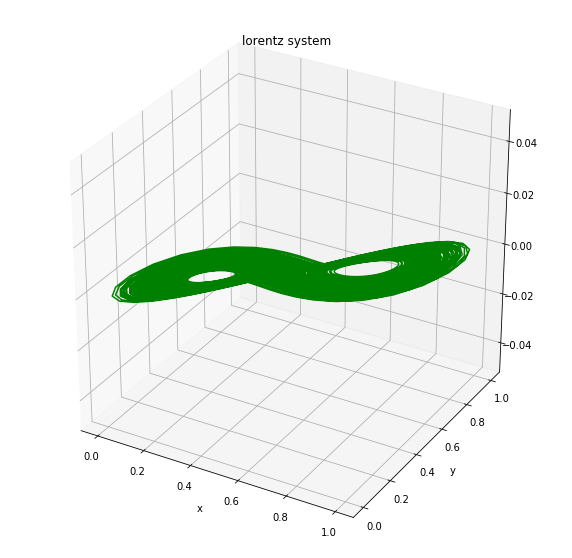

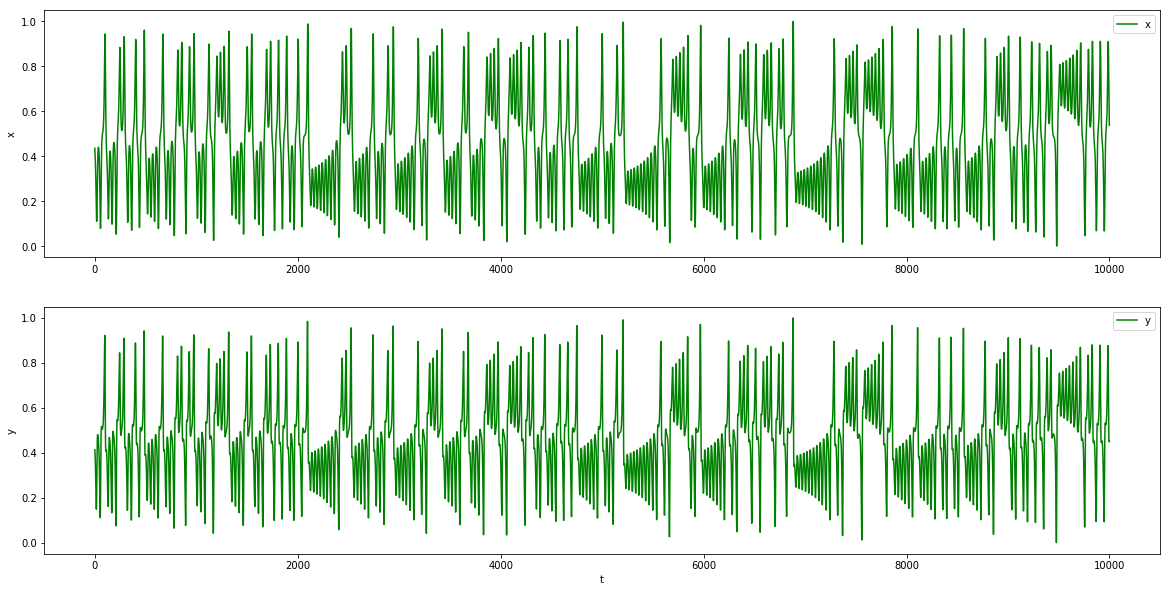

In [50]:

def show_dateset():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x, 'g')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(system_name + ' system')
    plt.savefig('../figures/' + system_name + '_system.pdf')
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.title(system_name)
    dim = ['x', 'y', 'z']
    for i in range(n_dim):
        plt.subplot(n_dim, 1, i + 1)
        plt.plot(x[i, :].T, color='g',label=dim[i])
        plt.ylabel(dim[i])
        plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.show()

show_dateset()

In [51]:
x_train = np.vstack([select_samples(x, train_start + i, num_train) for i in range(n)])
y_train = select_samples(x, train_start + n, num_train)

x_test = np.vstack([select_samples(x, test_start + i, num_test) for i in range(n)])  # test set
y_test = select_samples(x, test_start + n, num_test)

print('train set:', x_train.shape, y_train.shape)
print('test  set:', x_test.shape, y_test.shape)


train set: (20, 2000) (2, 2000)
test  set: (20, 2000) (2, 2000)


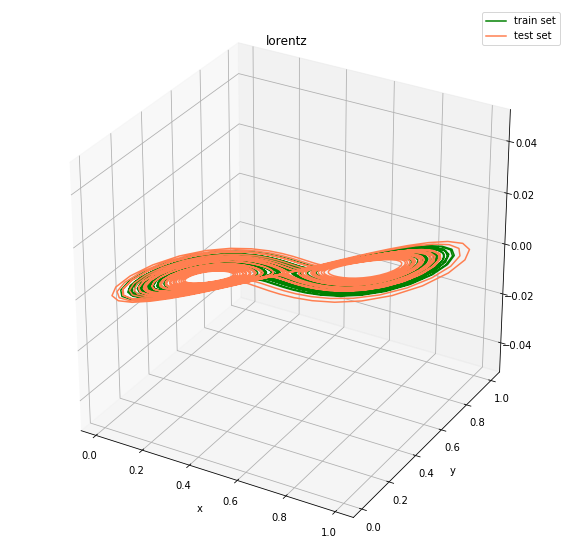

In [52]:
def show_train_test():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x_train[:n_dim, :], 'green', label='train set')
    plt.plot(*y_test, 'coral', label='test set')
    # plt.plot(*model.W_i[:,:3].T, 'ko',label='hidden layer')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(system_name)
    plt.savefig('../figures/' + system_name + '_split.pdf')
    plt.show()
show_train_test()

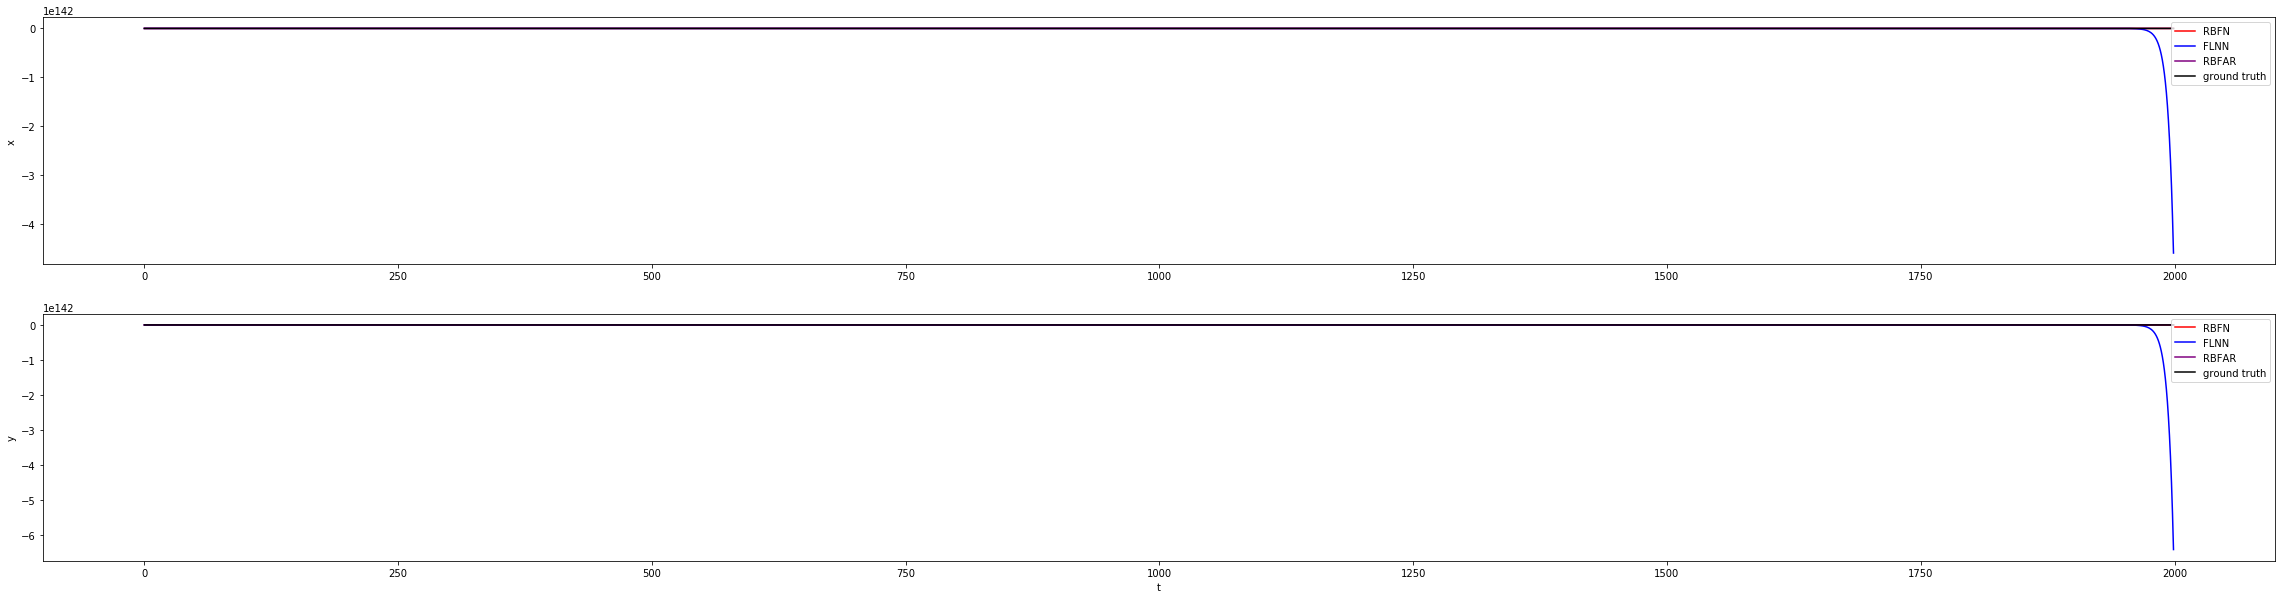

In [59]:
model_confs = [('RBFN', 200, 0, 0), 
               ('FLNN', 200, 1, 0),
               ('RBFAR', 200, 1, 1),
              ]
model_names = [conf[0] for conf in model_confs]

colors = ['red', 'blue', 'purple', 'green']


def single_step_experiment(use_pred = True):
    Predictions = [np.empty((n_dim, num_test)) for _ in range(len(model_confs))]


    for j, conf in enumerate(model_confs):
        model_name, n_neuron, skip_con, reweight = conf

        model = RBFNN(n_neuron,
                      skip_con=skip_con,
                      reweight=reweight
                      )

        model.train(x_train, y_train)
        p = x_test[:, :1]
        for i in range(num_test):
            p_next = model.predict(p)
            Predictions[j][:, i] = np.squeeze(p_next)
            if use_pred:
                p = np.vstack([p, p_next])[n_dim:]
            else:
                p = x_test[:, i + 1: i + 2]

    plt.figure(figsize=(40, 10))
    plt.title(system_name)
    dim = ['x', 'y', 'z']
    for i in range(n_dim):
        plt.subplot(n_dim, 1, i + 1)
        for j in range(len(model_confs)):
            plt.plot(Predictions[j][i, :].T, color=colors[j], label=model_names[j])
        plt.plot(y_test[i, :].T, color='black', label='ground truth')
        plt.ylabel(dim[i])
        plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.show()

single_step_experiment()

RBFN 200 0 0
FLNN 200 1 0
RBFAR 200 1 1


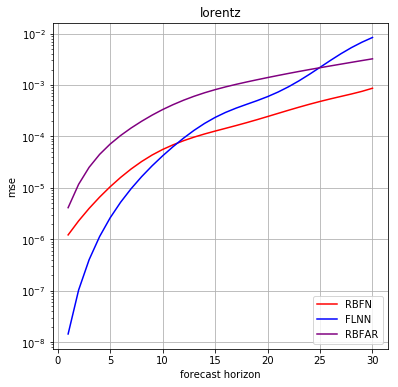

In [66]:


def multistep_experiment():
    fig, ax = plt.subplots(figsize=(6, 6))

    for conf, color in zip(model_confs, colors):
        model_name, n_neuron, skip_con, reweight = conf
        print(model_name, n_neuron, skip_con, reweight)

        model = RBFNN(n_neuron,
                      skip_con=skip_con,
                      reweight=reweight,
                      sigma = 10,
                      method = 'ridge'
                      )

        model.train(x_train, y_train)

        Y_mutistep = model.predict_multistep(x_test, horizon)
        Y_true = np.vstack([select_samples(x, test_start + n + i, num_test) for i in range(horizon)])

        mean_list = []
        for i in range(num_test):
            A = Y_mutistep[:, i:i + 1]
            B = Y_true[:, i:i + 1]
            err_list = error_multistep(mse, A, B, dim=n_dim)
            mean_list.append(err_list)

        mean_list = np.average(mean_list, axis=0)
        
        plt.plot([i + 1 for i in range(horizon)], mean_list, label=model_name, color=color)
        plt.ylabel('mse')
        plt.xlabel('forecast horizon')
        plt.grid(True)

    ax.set_yscale("log")
    plt.legend(loc='lower right')
    plt.title(system_name)
    # plt.savefig('../figures/' + system_name + '.pdf')
    plt.show()

multistep_experiment()

(60, 2000)


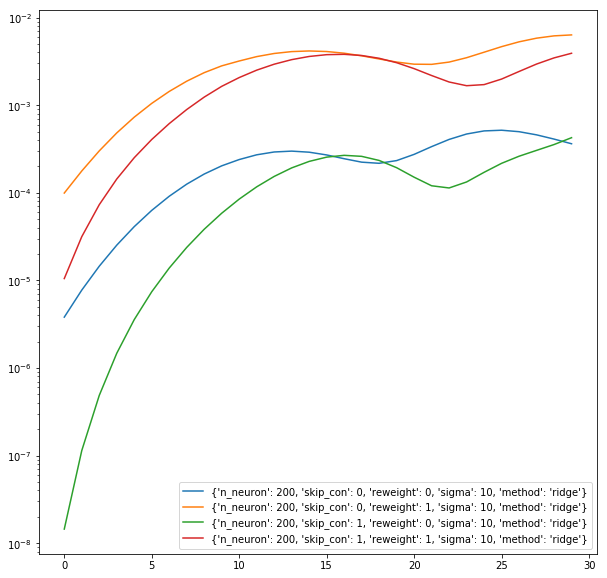

In [61]:


confs = {
    'n_neuron':[200],
    'skip_con':[0,1],
    'reweight':[0,1],
    'sigma':[10],
    'method':['ridge']
}

Y_true = np.vstack([select_samples(x, test_start + n + i, num_test) for i in range(horizon)])
print(Y_true.shape)

result = RBFNN.grid_search([x_train, y_train], [x_test, Y_true],confs)

fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(result)):
    line, confstr = result[i][0], str(result[i][1])
    plt.plot(line, label=confstr)
ax.set_yscale("log")
plt.legend()
plt.show()


In [65]:
a=0
if a:
    print(1)

In [ ]:
y_train

In [ ]:
import xgboost as xgb
def ml_model():

    
    from sklearn import svm
    reg = svm.SVR()
    reg.fit(x_train.T, y_train.T) 
    return  reg

model = ml_model()


In [ ]:
model.predict(x_test[:,0:1].T)

In [ ]:
help(xgb.XGBRegressor)

In [ ]:
x_test[:3,0]

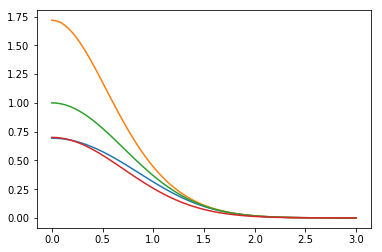

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def log_norm(x):
    return np.log(1+np.exp(-x))

def exp_norm(x):
    return np.exp(np.exp(-x))-1
x = np.linspace(0,3,100)

fig, ax = plt.subplots()
plt.plot(x,log_norm(x*x))
plt.plot(x,exp_norm(x*x))
plt.plot(x,np.exp(-x*x))
plt.plot(x, 0.7*np.exp(-x*x))
# ax.set_yscale("log")

In [12]:
conf =dict(a=1,b=2,c=3)

def set_conf(**conf):
    a = conf.get('a', 1)
    d = conf.get('d',5)
    print(a,d)

set_conf(**conf)

1 5


In [18]:
import numpy as np
np.vstack([1])

array([[1]])